# **UTMobileNet2021 Spark MLlib Analiz** 


### Kurulumlar

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!apt-get install openjdk-8-jdk-headless -qq 

In [2]:
!sudo add-apt-repository ppa:webupd8team/java
!sudo apt-get update
!sudo apt-get install oracle-java8-installer

 The Oracle JDK License has changed for releases starting April 16, 2019.

The new Oracle Technology Network License Agreement for Oracle Java SE is substantially different from prior Oracle JDK licenses. The new license permits certain uses, such as personal use and development use, at no cost -- but other uses authorized under prior Oracle JDK licenses may no longer be available. Please review the terms carefully before downloading and using this product. An FAQ is available here: https://www.oracle.com/technetwork/java/javase/overview/oracle-jdk-faqs.html

Oracle Java downloads now require logging in to an Oracle account to download Java updates, like the latest Oracle Java 8u211 / Java SE 8u212. Because of this I cannot update the PPA with the latest Java (and the old links were broken by Oracle).

For this reason, THIS PPA IS DISCONTINUED.

UPDATE:

For Oracle Java 17, see a different PPA -> https://www.linuxuprising.com/2021/09/how-to-install-oracle-java-17-lts-on.html

Old descr

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/UTMobileNet2021_analiz/

Mounted at /content/drive
/content/drive/My Drive/UTMobileNet2021_analiz


In [6]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

In [7]:
spark = SparkSession.builder \
      .master("local") \
      .appName("UTMobileNet2021_proje") \
      .config("spark.executor.memory", "12gb") \
      .getOrCreate()
    
sc = spark.sparkContext

In [8]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sbn
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras

1. Öznitelik adlarındaki "." yerine "_" konuldu.

2. Vector Assembler

3. MinMaxScaler

4. Train Test Split %80 - %20 (seed=42)

In [9]:
dataset = pd.read_csv("dataset_v2.csv")

In [10]:
dataset.tail(5)

,Unnamed: 0,frame.len,frame.cap_len,sll.pkttype,sll.hatype,sll.src.eth,sll.unused,ip.len,ip.id,ip.ttl,...,tcp.seq,tcp.ack,tcp.flags.fin,tcp.window_size_value,tcp.checksum,tcp.option_kind,tcp.option_len,tcp.options.timestamp.tsval,tcp.options.timestamp.tsecr,application
634953,680445,68,68,4,1,4,11368,52.0,60821,64.0,...,603.0,3939.0,0.0,386.0,45098,1,0,5.325970e+05,7.630374e+08,13
634954,680446,68,68,4,1,4,56718,52.0,38898,64.0,...,603.0,3940.0,0.0,386.0,45098,1,0,5.325970e+05,3.821468e+08,13
634955,680447,68,68,4,1,4,65352,52.0,54200,64.0,...,603.0,3939.0,0.0,385.0,45098,1,0,5.325970e+05,3.455872e+09,13
634956,686062,91,91,4,1,4,0,75.0,24716,64.0,...,1099.0,4224.0,0.0,394.0,11843,1,0,5.500930e+05,3.873080e+09,13
634957,686063,56,56,0,1,1,2708,40.0,44404,119.0,...,4224.0,0.0,0.0,0.0,19399,1,0,2.063930e+09,3.257399e+06,13


In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634958 entries, 0 to 634957
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   634958 non-null  int64  
 1   frame.len                    634958 non-null  int64  
 2   frame.cap_len                634958 non-null  int64  
 3   sll.pkttype                  634958 non-null  int64  
 4   sll.hatype                   634958 non-null  int64  
 5   sll.src.eth                  634958 non-null  int64  
 6   sll.unused                   634958 non-null  int64  
 7   ip.len                       634958 non-null  float64
 8   ip.id                        634958 non-null  int64  
 9   ip.ttl                       634958 non-null  float64
 10  ip.checksum                  634958 non-null  int64  
 11  ip.src                       634958 non-null  int64  
 12  ip.dst                       634958 non-null  int64  
 13 

In [12]:
dataset= dataset.drop(columns= ['Unnamed: 0',])

In [13]:
dataset = spark.createDataFrame(dataset)

In [14]:
dataset = dataset.toDF(*(c.replace('.', '_') for c in dataset.columns))

In [15]:
dataset.drop("application").toPandas().columns

Index(['frame_len', 'frame_cap_len', 'sll_pkttype', 'sll_hatype',
       'sll_src_eth', 'sll_unused', 'ip_len', 'ip_id', 'ip_ttl', 'ip_checksum',
       'ip_src', 'ip_dst', 'tcp_hdr_len', 'tcp_len', 'tcp_srcport',
       'tcp_dstport', 'tcp_seq', 'tcp_ack', 'tcp_flags_fin',
       'tcp_window_size_value', 'tcp_checksum', 'tcp_option_kind',
       'tcp_option_len', 'tcp_options_timestamp_tsval',
       'tcp_options_timestamp_tsecr'],
      dtype='object')

In [16]:
from pyspark.ml.feature import VectorAssembler

assemblerInput = ['frame_len', 'frame_cap_len', 'sll_pkttype', 'sll_hatype',
       'sll_src_eth', 'sll_unused', 'ip_len', 'ip_id', 'ip_ttl', 'ip_checksum',
       'ip_src', 'ip_dst', 'tcp_hdr_len', 'tcp_len', 'tcp_srcport',
       'tcp_dstport', 'tcp_seq', 'tcp_ack', 'tcp_flags_fin',
       'tcp_window_size_value', 'tcp_checksum', 'tcp_option_kind',
       'tcp_option_len', 'tcp_options_timestamp_tsval',
       'tcp_options_timestamp_tsecr']

assembler = VectorAssembler(inputCols= assemblerInput,  outputCol='vectorizedFeatures')

vectorized_dataset = assembler.transform(dataset)

In [17]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol='vectorizedFeatures', outputCol="scaledFeatures")
scalerModel = scaler.fit(vectorized_dataset)
scaled_Data = scalerModel.transform(vectorized_dataset)

In [18]:
dataset=scaled_Data.select("scaledFeatures", 'application')

In [38]:
train_data,test_data = dataset.randomSplit([0.8,0.2], seed=42)

### 1: RANDOM FOREST

In [39]:
# ----------------RANDOM FOREST ALGORİTMASI------------------

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='application', featuresCol='scaledFeatures', maxDepth=20, maxBins=50, seed=42)
model1 = rf.fit(train_data)
prediction1 = model1.transform(test_data)

In [40]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="application",predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction1)
print("Accuracy = %g" % (accuracy))

evaluator = MulticlassClassificationEvaluator(
    labelCol="application", predictionCol="prediction", metricName="f1")
F1_Score = evaluator.evaluate(prediction1)
print("F1 Score = %g" % (F1_Score))

evaluator = MulticlassClassificationEvaluator(
    labelCol="application", predictionCol="prediction", metricName="weightedPrecision")
Precision = evaluator.evaluate(prediction1)
print("Precision = %g" % (Precision))

evaluator = MulticlassClassificationEvaluator(
    labelCol="application", predictionCol="prediction", metricName="weightedRecall")
Recall = evaluator.evaluate(prediction1)
print("Recall = %g" % (Recall))

Accuracy = 0.99959
F1 Score = 0.999589
Precision = 0.999589
Recall = 0.99959


In [41]:
from sklearn.metrics import classification_report, confusion_matrix

y_true1 = prediction1.select("application").toPandas()
y_pred1 = prediction1.select("prediction").toPandas()

target_names = ["Facebook","Gmail","Google Drive","Google Maps","Hangouts",
                "Hulu", "Instagram","Messenger","Netflix","Pinterest","Reddit",
                "Spotify", "Twitter","Youtube"]
print(classification_report(y_true1, y_pred1, target_names = target_names))

              precision    recall  f1-score   support

    Facebook       1.00      1.00      1.00      4262
       Gmail       1.00      1.00      1.00       850
Google Drive       1.00      1.00      1.00     43524
 Google Maps       1.00      1.00      1.00      8349
    Hangouts       0.98      0.98      0.98       382
        Hulu       1.00      1.00      1.00     17032
   Instagram       1.00      1.00      1.00      9363
   Messenger       0.98      0.99      0.98       262
     Netflix       1.00      1.00      1.00     11780
   Pinterest       1.00      1.00      1.00     11816
      Reddit       1.00      1.00      1.00      7795
     Spotify       1.00      1.00      1.00      6753
     Twitter       1.00      1.00      1.00      4666
     Youtube       0.96      0.90      0.93        73

    accuracy                           1.00    126907
   macro avg       0.99      0.99      0.99    126907
weighted avg       1.00      1.00      1.00    126907



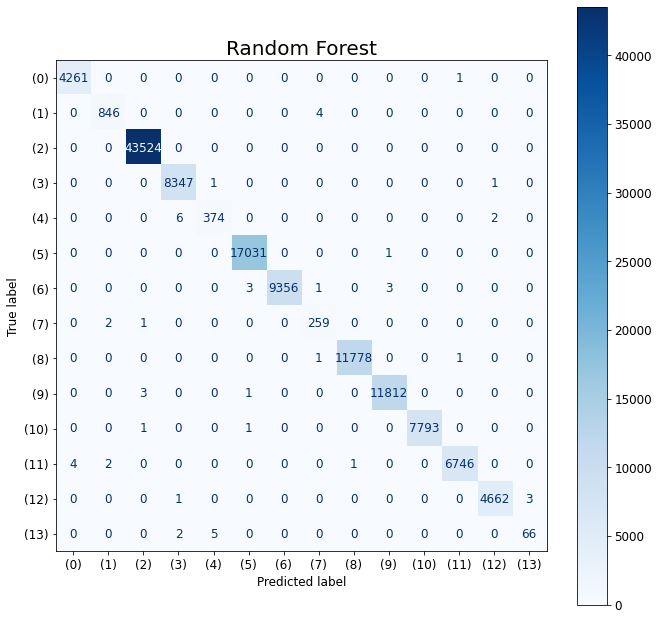

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true1, y_pred1)

target_names =["({})".format(i) for i in range(14)]
cmp = ConfusionMatrixDisplay(cm,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(11,11))
ax.set_title('Random Forest', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 12})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

### 2: DECISION TREE

In [43]:
#-----------------DECISION TREE ALGORİTMASI------------------------

from pyspark.ml.classification import DecisionTreeClassifier

dtr = DecisionTreeClassifier(labelCol='application', featuresCol='scaledFeatures', maxDepth=20, maxBins=50, seed=42)
model2 = dtr.fit(train_data)
predictions2 = model2.transform(test_data)

In [44]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="application",predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions2)
print("Accuracy = %g" % (accuracy))

evaluator = MulticlassClassificationEvaluator(
    labelCol="application", predictionCol="prediction", metricName="f1")
F1_Score = evaluator.evaluate(predictions2)
print("F1 Score = %g" % (F1_Score))

evaluator = MulticlassClassificationEvaluator(
    labelCol="application", predictionCol="prediction", metricName="weightedPrecision")
Precision = evaluator.evaluate(predictions2)
print("Precision = %g" % (Precision))

evaluator = MulticlassClassificationEvaluator(
    labelCol="application", predictionCol="prediction", metricName="weightedRecall")
Recall = evaluator.evaluate(predictions2)
print("Recall = %g" % (Recall))

Accuracy = 0.999133
F1 Score = 0.999132
Precision = 0.999131
Recall = 0.999133


In [45]:
from sklearn.metrics import classification_report, confusion_matrix

y_true2 = predictions2.select("application").toPandas()
y_pred2 = predictions2.select("prediction").toPandas()

target_names =  ["Facebook","Gmail","Google Drive","Google Maps","Hangouts",
                "Hulu", "Instagram","Messenger","Netflix","Pinterest","Reddit",
                "Spotify", "Twitter","Youtube"]
print(classification_report(y_true2, y_pred2, target_names = target_names))

              precision    recall  f1-score   support

    Facebook       1.00      1.00      1.00      4262
       Gmail       0.99      1.00      0.99       850
Google Drive       1.00      1.00      1.00     43524
 Google Maps       1.00      1.00      1.00      8349
    Hangouts       0.96      0.96      0.96       382
        Hulu       1.00      1.00      1.00     17032
   Instagram       1.00      1.00      1.00      9363
   Messenger       0.98      0.97      0.98       262
     Netflix       1.00      1.00      1.00     11780
   Pinterest       1.00      1.00      1.00     11816
      Reddit       1.00      1.00      1.00      7795
     Spotify       1.00      1.00      1.00      6753
     Twitter       1.00      1.00      1.00      4666
     Youtube       0.93      0.88      0.90        73

    accuracy                           1.00    126907
   macro avg       0.99      0.99      0.99    126907
weighted avg       1.00      1.00      1.00    126907



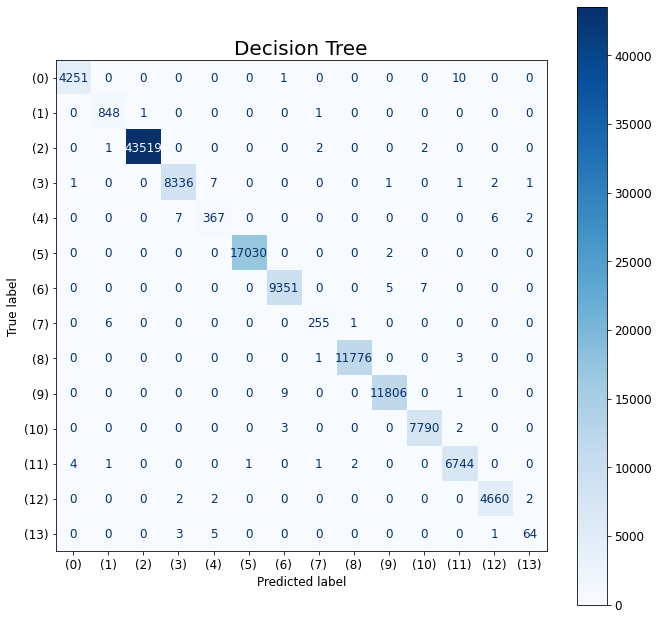

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

cm2 = confusion_matrix(y_true2, y_pred2)

target_names =["({})".format(i) for i in range(14)]
cmp = ConfusionMatrixDisplay(cm2,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(11,11))
ax.set_title('Decision Tree', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 12})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

### 3: NAIVE BAYES

In [47]:
#------------------NAIVE BAYES ALGORİTMASI-----------------

from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(labelCol="application", featuresCol="scaledFeatures", smoothing=1.0, modelType="multinomial")
model3 = nb.fit(train_data)
predictions3 = model3.transform(test_data)

In [48]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="application",predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions3)
print("Accuracy = %g" % (accuracy))

evaluator = MulticlassClassificationEvaluator(
    labelCol="application", predictionCol="prediction", metricName="f1")
F1_Score = evaluator.evaluate(predictions3)
print("F1 Score = %g" % (F1_Score))

evaluator = MulticlassClassificationEvaluator(
    labelCol="application", predictionCol="prediction", metricName="weightedPrecision")
Precision = evaluator.evaluate(predictions3)
print("Precision = %g" % (Precision))

evaluator = MulticlassClassificationEvaluator(
    labelCol="application", predictionCol="prediction", metricName="weightedRecall")
Recall = evaluator.evaluate(predictions3)
print("Recall = %g" % (Recall))

Accuracy = 0.494953
F1 Score = 0.395997
Precision = 0.49269
Recall = 0.494953


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

y_true3 = predictions3.select("application").toPandas()
y_pred3 = predictions3.select("prediction").toPandas()

target_names = ["Facebook","Gmail","Google Drive","Google Maps","Hangouts",
                "Hulu", "Instagram","Messenger","Netflix","Pinterest","Reddit",
                "Spotify", "Twitter","Youtube"]
print(classification_report(y_true3, y_pred3, target_names = target_names))

              precision    recall  f1-score   support

    Facebook       0.00      0.00      0.00      4262
       Gmail       0.00      0.00      0.00       850
Google Drive       0.42      1.00      0.60     43524
 Google Maps       0.67      0.80      0.73      8349
    Hangouts       0.00      0.00      0.00       382
        Hulu       0.88      0.42      0.57     17032
   Instagram       0.00      0.00      0.00      9363
   Messenger       0.00      0.00      0.00       262
     Netflix       0.94      0.21      0.35     11780
   Pinterest       0.01      0.00      0.00     11816
      Reddit       1.00      0.36      0.53      7795
     Spotify       0.00      0.00      0.00      6753
     Twitter       0.97      0.04      0.07      4666
     Youtube       0.00      0.00      0.00        73

    accuracy                           0.49    126907
   macro avg       0.35      0.20      0.20    126907
weighted avg       0.49      0.49      0.40    126907



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


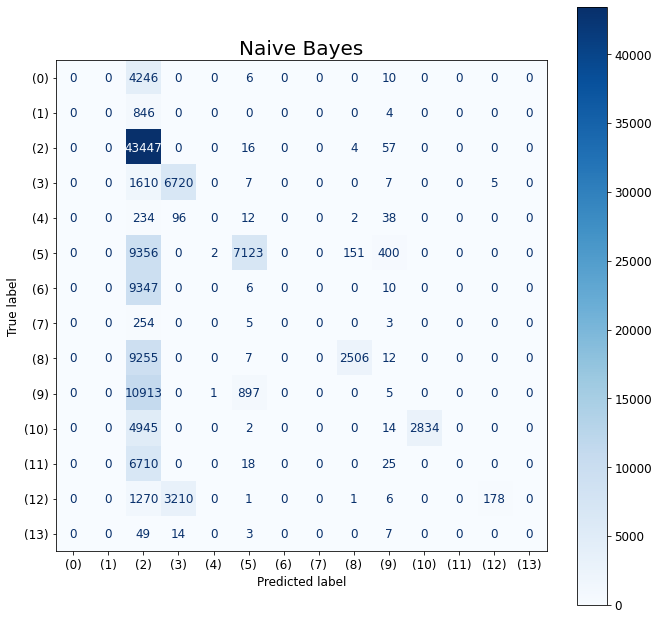

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay

cm3 = confusion_matrix(y_true3, y_pred3)

target_names =["({})".format(i) for i in range(14)]
cmp = ConfusionMatrixDisplay(cm3,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(11,11))
ax.set_title('Naive Bayes', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 12})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

### 4: LOGISTIC RESGRESSION

In [51]:
#------------------ LOGISTIC RESGRESSION ALGORİTMASI------------------
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="application", featuresCol='scaledFeatures')
model4 = lr.fit(train_data)
predictions4 = model4.transform(test_data)

In [52]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="application",predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions4)
print("Accuracy = %g" % (accuracy))

evaluator = MulticlassClassificationEvaluator(
    labelCol="application", predictionCol="prediction", metricName="f1")
F1_Score = evaluator.evaluate(predictions4)
print("F1 Score = %g" % (F1_Score))

evaluator = MulticlassClassificationEvaluator(
    labelCol="application", predictionCol="prediction", metricName="weightedPrecision")
Precision = evaluator.evaluate(predictions4)
print("Precision = %g" % (Precision))

evaluator = MulticlassClassificationEvaluator(
    labelCol="application", predictionCol="prediction", metricName="weightedRecall")
Recall = evaluator.evaluate(predictions4)
print("Recall = %g" % (Recall))

Accuracy = 0.862009
F1 Score = 0.856961
Precision = 0.861116
Recall = 0.862009


In [53]:
from sklearn.metrics import classification_report, confusion_matrix

y_true4 = predictions4.select("application").toPandas()
y_pred4 = predictions4.select("prediction").toPandas()

target_names = ["Facebook","Gmail","Google Drive","Google Maps","Hangouts",
                "Hulu", "Instagram","Messenger","Netflix","Pinterest","Reddit",
                "Spotify", "Twitter","Youtube"]
print(classification_report(y_true4, y_pred4, target_names = target_names))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Facebook       0.76      0.58      0.66      4262
       Gmail       0.42      0.01      0.01       850
Google Drive       0.91      0.98      0.94     43524
 Google Maps       0.92      0.97      0.94      8349
    Hangouts       0.43      0.03      0.06       382
        Hulu       0.94      0.79      0.86     17032
   Instagram       0.80      0.83      0.81      9363
   Messenger       0.00      0.00      0.00       262
     Netflix       0.92      0.81      0.86     11780
   Pinterest       0.81      0.86      0.83     11816
      Reddit       0.86      0.88      0.87      7795
     Spotify       0.54      0.69      0.60      6753
     Twitter       0.87      0.83      0.85      4666
     Youtube       0.00      0.00      0.00        73

    accuracy                           0.86    126907
   macro avg       0.66      0.59      0.59    126907
weighted avg       0.86      0.86      0.86    126907



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


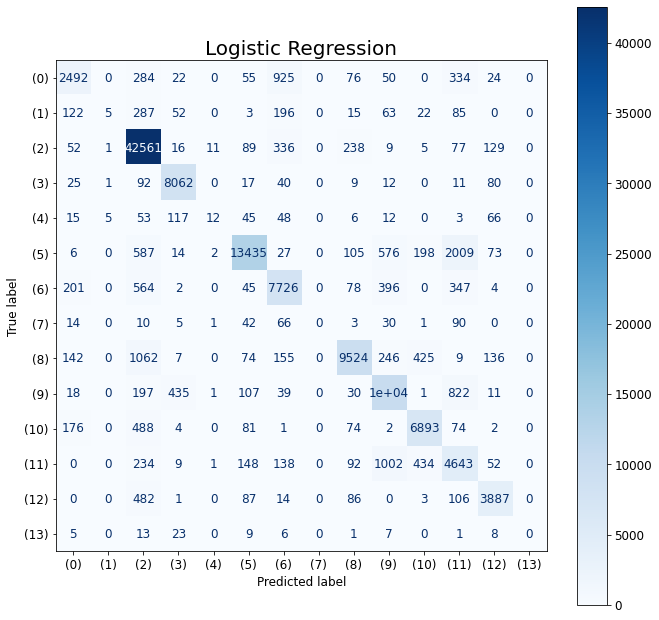

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay

cm4 = confusion_matrix(y_true4, y_pred4)

target_names =["({})".format(i) for i in range(14)]
cmp = ConfusionMatrixDisplay(cm4,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(11,11))
ax.set_title('Logistic Regression', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 12})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

### 5: MLP

In [55]:
#--------------------MULTILAYER PERCEPTRON ALGORİTMASI-------------------

layers = [25,33,14] 

from pyspark.ml.classification import MultilayerPerceptronClassifier

mpc = MultilayerPerceptronClassifier(labelCol='application', featuresCol="scaledFeatures", 
                        maxIter=100, layers=layers, blockSize=128, seed=42)
model5 = mpc.fit(train_data)
predictions5 = model5.transform(test_data)

In [56]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="application",predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions5)
print("Accuracy = %g" % (accuracy))

evaluator = MulticlassClassificationEvaluator(
    labelCol="application", predictionCol="prediction", metricName="f1")
F1_Score = evaluator.evaluate(predictions5)
print("F1 Score = %g" % (F1_Score))

evaluator = MulticlassClassificationEvaluator(
    labelCol="application", predictionCol="prediction", metricName="weightedPrecision")
Precision = evaluator.evaluate(predictions5)
print("Precision = %g" % (Precision))

evaluator = MulticlassClassificationEvaluator(
    labelCol="application", predictionCol="prediction", metricName="weightedRecall")
Recall = evaluator.evaluate(predictions5)
print("Recall = %g" % (Recall))

Accuracy = 0.922463
F1 Score = 0.919375
Precision = 0.92221
Recall = 0.922463


In [57]:
from sklearn.metrics import classification_report, confusion_matrix

y_true5 = predictions5.select("application").toPandas()
y_pred5 = predictions5.select("prediction").toPandas()

target_names = ["Facebook","Gmail","Google Drive","Google Maps","Hangouts",
                "Hulu", "Instagram","Messenger","Netflix","Pinterest","Reddit",
                "Spotify", "Twitter","Youtube"]
print(classification_report(y_true5, y_pred5, target_names = target_names))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Facebook       0.90      0.61      0.73      4262
       Gmail       0.64      0.44      0.52       850
Google Drive       0.94      0.99      0.97     43524
 Google Maps       0.99      0.97      0.98      8349
    Hangouts       0.66      0.42      0.51       382
        Hulu       0.94      0.87      0.90     17032
   Instagram       0.85      0.94      0.89      9363
   Messenger       1.00      0.00      0.01       262
     Netflix       0.95      0.94      0.94     11780
   Pinterest       0.87      0.95      0.91     11816
      Reddit       0.98      0.91      0.95      7795
     Spotify       0.78      0.78      0.78      6753
     Twitter       0.96      0.96      0.96      4666
     Youtube       0.00      0.00      0.00        73

    accuracy                           0.92    126907
   macro avg       0.82      0.70      0.72    126907
weighted avg       0.92      0.92      0.92    126907



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


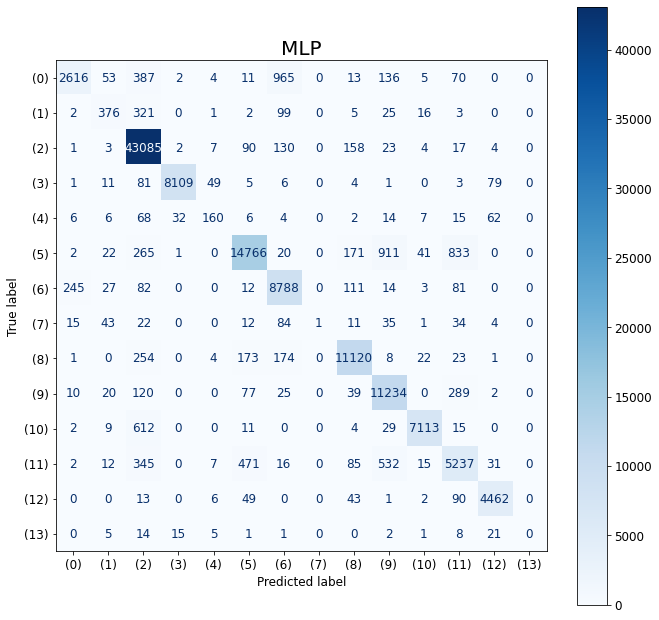

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay

cm5 = confusion_matrix(y_true5, y_pred5)

target_names =["({})".format(i) for i in range(14)]
cmp = ConfusionMatrixDisplay(cm5,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(11,11))
ax.set_title('MLP', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 12})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()